# La segmentazione cliente con il clustering k-means (non gerarchico)

Non ci sono filtri decisi dall'utente. La riga è considerata <u>nel suo insieme</u>. <br>
Il Clustering (k-means, HC, od altro) permette all'attributo discriminativo di agire. Noi non sappiamo a priori quali siano gli attributi più discriminativi. Nella segmentazione *manuale* la scelta dell'attributo è invece rigida e guidata dall'utente.<br>
Inoltre, l'uso di metriche di **distanza** (le vedremo) permette di **pesare** le singole variabili in modo differente, pur utilizzandole <u>tutte</u> (non possibile nella segmentazione manuale).

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.display import Image                     # per importare in una cella di tipo CODICE un'immagine

In [3]:
# abilitare la Table Of Contents (ToC) - stack overflow 21151450
# The jupyterlab-toc extension adds the ToC as a side panel that can number headings, collapse sections, and be used for 
# navigation. This extension is included by default since JupyterLab 3.0, in older version you can install it with the following
# command (from a conda prompt, which is NOT the DOS shell):
# - pip install jupyter_contrib_nbextensions
# - jupyter contrib nbextension install --user
# - chiudere e riaprire conda
# --> nella home di Jupyter compare ora un quarto tab, da configurare.

# Caricare i dati
Il dataset è disponibile su [kaggle](https://www.kaggle.com/datasets/mrmining/online-retail?select=Online+Retail.xlsx).

In [4]:
df = pd.read_excel('Online Retail.xlsx', sheet_name='Online Retail') # 'read_excel' richiede anche il nome del foglio,
                                                                     # a differenza di 'read_csv'.
                                          # tempo di esecuzione: 
                                          # circa 1'15" su laptop Fujitsu con Intel i7 2.20GHz, 8 GB RAM; 
                                          # circa 40" su desktop Intel i5 4.9ghz 12mb cache, 16 GB RAM.
            
                                          # Architettura hardware (Windows 10) consigliata per ML:
                                          # - processori i5/i7 (i9 eccessivo);
                                          # - frequenza (ghz) del processore: almeno 4 ghz;
                                          # - consigliabili processori della 11-a generazione (hanno
                                          #   facility per le reti neurali);
                                          # - 6/8 core (molti algoritmi di ML sono parallelizzabili);
                                          # - 12/16 GB RAM;
                                          # - GPU NVIDIA (utilizzata da alcuni software per math o 3D).
                                          # - TSU di Google Colab
              
                                          # Architettura hardware (Apple) consigliata per ML:
                                          # - processori M1;
                                          # - 8 GB RAM unificata.
                        
                                          # La libreria ottimizzata per i chip M1 di Apple sfrutta il nuovo framework ML Compute
                                          # (di Apple), che ha lo scopo di accelerare l'addestramento delle reti neurali 
                                          # impiegando non solo le CPU, ma anche tutte le GPU disponibili.  
                                          # Il nuovo framework ML Compute di Apple è incluso nell’ultimo aggiornamento di macOS,
                                          # Big Sur, e consente agli utenti di TensorFlow di sfruttare tutto il potenziale della
                                          # CPU a 8 core e della GPU a 8 core del chip M1.
                                          
                                          # In generale, non indispensabili per ML (perchè a-specifici):
                                          # - dischi allo stato solido (SSD);
                                          # - scheda grafica avanzata (salvo l'aspetto delle GPU).



In [7]:
# se avete problemi a caricare un file .xlsx (abbastanza frequente!), create la versione .csv del suddetto file e poi:
df = pd.read.csv(('Online Retail.csv')

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_11744/3796512640.py, line 2)

In [48]:
df.shape

(380620, 9)

In [49]:
df.head() # --> una fattura può avere diversi prodotti, come si può notare (dataset non normalizzato secondo le Codd NF)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [50]:
df.nunique() # il numero di elementi distinti per ogni attributo

InvoiceNo      17758
StockCode       3657
Description     3868
Quantity         294
InvoiceDate    16581
UnitPrice        426
CustomerID      4298
Country           37
Sales           2872
dtype: int64

In [51]:
# verifichiamo qual è l'indice
df.index # indice di default numerico

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            516359, 516360, 516361, 516362, 516363, 516364, 516365, 516366,
            516367, 516368],
           dtype='int64', length=380620)

# Pulire / preparare i dati
Prima di segmentare spesso occorre pulire i dati e preparali alla modellazione. 5 passi, in questo caso:
* Eliminare gli ordini cancellati (con quantità negativa o zero);
* Eliminare gli ordini senza CustomerId;
* Eliminare le date incomplete;
* Calcolare il totale riga (dalle colonne 'Quantity' e 'UnitPrice');
* Raggruppare per cliente (perchè vogliamo fare una segmentazione clienti).

## Escludere le righe con Quantity negativa/zero

In [52]:
df.loc[df['Quantity'] <= 0].shape  # 10.000+ record cancellati (quantità negativa o zero)

(0, 9)

In [53]:
df.shape                           # dimensioni totali (già viste prima, qui nuovamente riportate per comodità)

(380620, 9)

In [54]:
df = df.loc[df['Quantity'] > 0]    # sovrascrittura dei soli record con quantità positiva

In [55]:
df.shape

(380620, 9)

## Escludere le righe con CustomerID mancante

In [56]:
pd.isnull(df['CustomerID']).sum()

0

In [57]:
df = df[pd.notnull(df['CustomerID'])]

In [58]:
df.shape

(380620, 9)

## Escludere le righe con mese incompleto
Il dataset ha alcune date incomplete nel mese di dicembre 2011.

In [59]:
print('Date Range: %s ~ %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max())) # stampa il range delle date;
                                                                                  # argomenti: formato, valore min, valore max.

Date Range: 2010-12-01 08:26:00 ~ 2011-11-30 17:37:00


In [60]:
df.loc[df['InvoiceDate'] >= '2011-12-01'].shape # le date potenzialmente errate.

(0, 9)

In [61]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']   # sovrascrittura dei soli record con data corretta

In [62]:
df.shape

(380620, 9)

## Calcolare i totali di riga

In [63]:
df['Sales'] = df['Quantity'] * df['UnitPrice']  # creazione di una nuova colonna (in coda) per ogni record.
# Nel ML le righe del dataset sono in genere chiamate: osservazioni, casi, unità statistiche, punti (non 'record').
# Le colonne sono in genere chiamate: colonne, attributi, feature, variabili, dimensioni, predittori, regressori, ecc.

In [64]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08


## Aggregare i dati per *CustomerId*
Per segmentare i clienti, occorre prima trasformare il dataset raggruppando i dati per cliente. <br>
3 passi.

In [65]:
# 1) raggruppamento per 'CustomerID' su due attributi: Sales e InvoiceNo:
customer_df = df.groupby('CustomerID').agg({   # in Python c'è la consuetudine di usare "_" nei nomi delle variabili. In R, ".".
                                               # .agg è il metodo pandas per definire quali funzioni di aggregazione eseguire
                                               # su ogni raggruppamento individuato dalla 'groupby'.
    'Sales': sum,
    'InvoiceNo': lambda x: x.nunique()         # le funzioni 'lambda', in Python come in altri linguaggi (jAVA, C#, C++, ecc),
                                               # si basano sul lambda calcolo, ed hanno una sintassi più restrittiva ma 
                                               # particolarmente concisa, a differenza delle funzioni regolari (macchina di 
                                               # Turing a stati: funzioni imperative).
})

customer_df.head()

,Sales,InvoiceNo
CustomerID,,
12346.0,77183.60,1
12347.0,4085.18,6
12348.0,1797.24,4
12349.0,1757.55,1
12350.0,334.40,1


In [66]:
# 2)
customer_df.columns = ['TotalSales', 'OrderCount']  # i due attributi (colonne) vengono rinominate più correttamente.
                                                    # NB. Nel passo 1) ciò non era possibile, perchè i nomi degli attributi
                                                    # della funzione 'groupby' e del metodo 'agg' debbono essere quelli del
                                                    # dataset originario.
customer_df.head()

,TotalSales,OrderCount
CustomerID,,
12346.0,77183.60,1
12347.0,4085.18,6
12348.0,1797.24,4
12349.0,1757.55,1
12350.0,334.40,1


In [67]:
customer_df.shape

(4298, 2)

In [68]:
# 3) creazione di un terzo attributo
customer_df['AvgOrderValue'] = customer_df['TotalSales']/customer_df['OrderCount']

In [69]:
customer_df.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000


In [70]:
customer_df.describe() # la distribuzione dei tre attributi: numero, media, deviazione standard (la radice quadrata della 
                       # varianza), min, max, i tre quantili al 25%, 50% e 75%. 
                       # Il quantile al 50% è anche chiamato 'mediana'.
                       # --> poichè la std (standard deviation) è differente tra le colonne, per applicare correttamente
                       # il clustering (di qualsiasi tipo, cioè k-means e HC) occorre pre-standardizzare i dati.

,TotalSales,OrderCount,AvgOrderValue
count,4298.000000,4298.000000,4298.000000
mean,1952.818779,4.131689,400.255621
std,8354.913254,7.420253,1271.187289
min,0.000000,1.000000,0.000000
25%,304.305000,1.000000,178.602500
50%,657.265000,2.000000,295.033958
75%,1599.515000,4.000000,431.594250
max,268478.000000,201.000000,77183.600000


In [71]:
customer_df['TotalSales'].median()  # La mediana (= quantile al 50%).
                                    # E' una misura 'robusta' perchè meno sensibile della media agli outlier.

657.265

In [72]:
# Mediana vs media (esempio)
sr = pd.Series([10,25,3,11,24,6,1800])
index_ = ['Coca Cola','Sprite','Fanta','Liquore','Caffè','Thè','Cappuccino']
sr.index = index_
print(sr.mean())
print(sr.sort_values())
print(sr.median())

268.42857142857144
Fanta            3
Thè              6
Coca Cola       10
Liquore         11
Caffè           24
Sprite          25
Cappuccino    1800
dtype: int64
11.0


In [73]:
# Per ordinare il nostro dataset ridotto:
customer_df.sort_values(by='TotalSales')

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
13256.0,0.00,1,0.000000
16446.0,2.90,1,2.900000
16738.0,3.75,1,3.750000
14792.0,6.20,1,6.200000
16454.0,6.90,2,3.450000
...,...,...,...
12415.0,124914.53,21,5948.310952
14911.0,136846.14,192,712.740313
17450.0,192988.39,45,4288.630889


In [74]:
# Come mai un cliente con TotalSales = 0? Non erano stati esclusi??
df[df['CustomerID']==13256] # NON escluso prima perchè qui Quantity>0. Ma UnitPrice=0 --> Sales e poi TotalSales = 0!

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,0.0


In [75]:
# Un altro possibile ordinamento:
customer_df.sort_values(by='OrderCount')

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
16830.0,325.91,1,325.910000
14453.0,119.93,1,119.930000
16834.0,413.46,1,413.460000
14439.0,2661.24,1,2661.240000
...,...,...,...
14606.0,11800.94,91,129.680659
13089.0,54144.21,93,582.195806
17841.0,38435.26,120,320.293833


In [76]:
customer_df.describe() # ??

,TotalSales,OrderCount,AvgOrderValue
count,4298.000000,4298.000000,4298.000000
mean,1952.818779,4.131689,400.255621
std,8354.913254,7.420253,1271.187289
min,0.000000,1.000000,0.000000
25%,304.305000,1.000000,178.602500
50%,657.265000,2.000000,295.033958
75%,1599.515000,4.000000,431.594250
max,268478.000000,201.000000,77183.600000


## *Ranking* e Standardizzazione
Come facilmente visibile dalle statistiche fornite dal metodo *describe* di sopra, i tre attributi hanno scale (*std*) molto differenti. Gli algoritmi di clustering hanno bisogno che gli attributi siano espressi nella stessa scala. Serve 
la standardizzazione.<br><br>
Inoltre, è spesso meglio esprimere i dati come POSIZIONE ("rank") all'interno del dataset, anzichè come VALORE.<br>
Infatti noi vogliamo segmentare e dunque ci interessano le posizioni di un cliente rispetto agli altri e non i suoi valori 
in assoluto.

In [77]:
# Esempio di ranking (su una 'Series', un altro oggetto di pandas) A PRESCINDERE dal nostro dataset
sr = pd.Series([10,25,3,11,24,60,87])
index_ = ['Coca Cola','Sprite','Fanta','Liquore','Caffè','Thè','Cappuccino']
sr.index = index_
print(sr)
result = sr.rank(ascending=True)
print("\n")   # salta riga
print(result) # attenzione: senza 'print' è visualizzato solo l'ultimo output.
print(sr.median()) # --> attenzione, la mediana è il valore del vettore (colonna del df) con tanti valori maggiori
                   #     quanti sono i valori minori. Il rank è la posizione del valore singolo rispetto a tutti gli altri.
                   #     OGNI riga ha il suo rank, solo UNA riga è la mediana.

Coca Cola     10
Sprite        25
Fanta          3
Liquore       11
Caffè         24
Thè           60
Cappuccino    87
dtype: int64


Coca Cola     2.0
Sprite        5.0
Fanta         1.0
Liquore       3.0
Caffè         4.0
Thè           6.0
Cappuccino    7.0
dtype: float64
24.0


In [78]:
# NB. Rank NON è l'ordinamento, ma la posizione rispetto a TUTTI gli elementi del vettore considerato. Non confondere!
# Per ordinare la serie di prima:
print(sr.sort_values())

Fanta          3
Coca Cola     10
Liquore       11
Caffè         24
Sprite        25
Thè           60
Cappuccino    87
dtype: int64


In [79]:
# ed ora il ranking del nostro dataset ridotto:
rank_df = customer_df.rank(method='first')  # l'argomento 'method':
                                            # dall'help on-line: "How to rank the group of records that have the same 
                                            # value (i.e. ties)
        
rank_df.head(15)    # --> sono POSIZIONI (non valori)
                    # le posizioni di ogni attributo vanno da 1 a 4298.
          
                    # Notare l'effetto dell'argomento 'method': alle varie osservazioni con 'OrderCount' = 1 (molte!)
                    # sono assegnati rank crescenti! Cioè, ad esempio, ai clienti 12346, 12349 e 12350, che hanno tutti e
                    # tre 'OrderCount' = 1, sono assegnati rank crescenti (1 --> 2 --> 3). In questo modo tutti gli
                    # attributi hanno rank massimo = 4298 (il numero di osservazioni).
                    
                    # nota estetica: 'print' in questo caso produrrebbe un output meno gradevole (dipende dai casi)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4290.0,1.0,4298.0
12347.0,3958.0,3470.0,3888.0
12348.0,3350.0,2861.0,3303.0
12349.0,3321.0,2.0,4238.0
12350.0,1241.0,3.0,2561.0
12352.0,3630.0,3774.0,2360.0
12353.0,119.0,4.0,201.0
12354.0,2781.0,5.0,4151.0
12355.0,1670.0,6.0,3354.0


In [80]:
rank_df.shape  # stesse dimensioni, ma ogni elemento è una posizione (nella singola colonna presa a se stante),
               # anzichè un valore

(4298, 3)

In [81]:
# Poichè il CustomerID 12346 aveva un TotalSales tra i più alti, gli è assegnata la POSIZIONE 4290 (molto vicino a 4298,
# che è il numero totale dei clienti nel dataframe).
customer_df.head(20)                # --> VALORI (non posizioni), come check.
                                    #     qui, tra i primi 20 il Customer ID 12346 ha il TotalSales più alto, in effetti.



,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000
12352.0,2506.04,8,313.255000
12353.0,89.00,1,89.000000
12354.0,1079.40,1,1079.400000
12355.0,459.40,1,459.400000


In [82]:
customer_df.corr()

,TotalSales,OrderCount,AvgOrderValue
TotalSales,1.000000,0.575523,0.292106
OrderCount,0.575523,1.000000,0.031715
AvgOrderValue,0.292106,0.031715,1.000000


In [83]:
import numpy as np
np.linalg.matrix_rank(customer_df)

3

In [84]:
# è possibile ordinare le POSIZIONI:
rank_df.sort_values(by='OrderCount') 

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,4290.0,1.0,4298.0
12349.0,3321.0,2.0,4238.0
12350.0,1241.0,3.0,2561.0
12353.0,119.0,4.0,201.0
12354.0,2781.0,5.0,4151.0
...,...,...,...
14606.0,4223.0,4294.0,533.0
13089.0,4284.0,4295.0,3714.0
17841.0,4276.0,4296.0,2428.0


In [85]:
# ed ora standardizziamo i dati (aka, normalizzazione) - esistono anche delle funzioni di scikit-learn:
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()

In [86]:
normalized_df.head(15) # --> la standardizzazione è fattibile per qualsiasi dato NUMERICO, quindi sia con i VALORI che 
                       #     con le POSIZIONI.

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724999,-1.731446,1.731446
12347.0,1.457445,1.064173,1.401033
12348.0,0.967466,0.573388,0.929590
12349.0,0.944096,-1.730641,1.683093
12350.0,-0.732148,-1.729835,0.331622
12352.0,1.193114,1.309162,0.169639
12353.0,-1.636352,-1.729029,-1.570269
12354.0,0.508917,-1.728223,1.612981
12355.0,-0.386422,-1.727417,0.970690


In [87]:
customer_df = (customer_df - customer_df.mean()) / customer_df.std() # la standardizzazione sui VALORI (di tutte le righe)
customer_df.head(15)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,9.004376,-0.422046,60.402857
12347.0,0.255222,0.251785,0.220745
12348.0,-0.018621,-0.017747,0.038589
12349.0,-0.023372,-0.422046,1.067738
12350.0,-0.193709,-0.422046,-0.051806
12352.0,0.066215,0.521318,-0.068440
12353.0,-0.223081,-0.422046,-0.244854
12354.0,-0.104540,-0.422046,0.534260
12355.0,-0.178747,-0.422046,0.046527


In [88]:
normalized_df.describe() # --> le POSIZIONI sono centrate intorno a 0 e soprattutto le std sono 1, ora!
                         #     Ora siamo pronti a segmentare.

,TotalSales,OrderCount,AvgOrderValue
count,4.298000e+03,4.298000e+03,4.298000e+03
mean,9.084817e-17,-1.231371e-16,3.569866e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.731446e+00,-1.731446e+00,-1.731446e+00
25%,-8.657232e-01,-8.657232e-01,-8.657232e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.657232e-01,8.657232e-01,8.657232e-01
max,1.731446e+00,1.731446e+00,1.731446e+00


# La Segmentazione Cliente con il clustering K-Means 

Clustering refers to a very broad set of techniques for finding subgroups, or clustering clusters, in a data set. When we cluster the observations of a data set, we seek to **<u>partition</u>** them into distinct groups so that **the observations within each group are quite similar to each other, while observations in different groups are quite different from each other**. Of course, to make this concrete, we must define what it means for two or more observations to be similar or different (the so-called ***distance***). Indeed, this is often a domain-specific consideration that must be made based on knowledge of the data being studied.

The goal in customer segmentation is to identify subgroups of people who might be <u>more receptive to a particular form of advertising, or more likely to purchase a particular product</u>. [Questa è una **assunzione**, spesso vera]. The task of performing customer segmentation amounts to clustering the people in the data set.

Since clustering is popular in many fields, there exist a great number of clustering methods. The two best-known clustering approaches are</u>: **K-means clustering** and **hierarchical clustering**.<br><br>
In K-means clustering, we seek to partition the observations into a <u>pre-specified number of clusters</u>. On the other hand, in hierarchical clustering, we <u>do not know in advance</u> how many clusters we want; in fact, we end up with a tree-like visual representation of the observations, called a **dendrogram**, that allows us to view at once the clusterings obtained for each possible number of clusters, from 1 to n.<br><br> There are **advantages and disadvantages** to each of these clustering approaches. 

*James, Gareth; Witten, Daniela; Hastie, Trevor; Tibshirani, Robert. An Introduction to Statistical Learning: with Applications in R (Springer Texts in Statistics)* 

E se ci sono anche nel dataframe delle variabili **categoriche** (ad es. la regione del cliente) che vogliamo siano considerate dalla segmentazione?
* La standardizzazione ed il ranking hanno senso SOLO per le variabili numeriche; teniamo la variabile categorica così com'è;
* esistono tipi di distanze tra osservazioni (le vedremo tra poco) che calcolano la distanza tenendo conto sia delle variabili numeriche che di quelle categoriche.

[Il Clustering in scikit-learn](https://scikit-learn.org/stable/modules/clustering.html)<br>
[La funzione KMeans di scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [89]:
from sklearn.cluster import KMeans   # import del modulo di kmeans da scikit_learn.

C:\Users\Utente\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## K-Means Clustering [Nota matematica facoltativa]
K-means clustering is a simple and elegant approach for <u>partitioning</u> a data set into **K distinct, non-overlapping clusters**. 

[Cos'è un partizionamento in matematica](https://it.wikipedia.org/wiki/Partizione_(teoria_degli_insiemi)#:~:text=In%20matematica%20una%20partizione%20di,%22coprono%22%20X%20senza%20sovrapporsi.&text=dati%20due%20sottoinsiemi%20(distinti)%20qualsiasi,di%20X%2C%20questi%20sono%20disgiunti.)<br>
[Un esempio di partizionamento](https://www.google.com/search?q=partizionamento&rlz=1C2WPZC_enIT808IT808&sxsrf=AOaemvKnkeeYdX2yV4gRuOwAVikij_BZrQ:1632684189067&source=lnms&tbm=isch&sa=X&ved=2ahUKEwia4_nIrp3zAhVJhv0HHYukCa0Q_AUoBHoECAEQBg&biw=1536&bih=722&dpr=1.25#imgrc=N6YwgLO4HuyrcM)

The K-means clustering procedure results from a simple and intuitive mathematical problem. We begin by defining some notation. Let C1,...,CK denote sets containing the indices of the observations in each cluster. These sets satisfy two properties:<br>
* C1 ∪ C2 ∪... ∪ CK = {1,...,n}. In other words, each observation belongs to at least one of the K clusters.<br>
* Ck ∩ Ck' = ∅ for all k != k'. In other words, the clusters are nonoverlapping: no observation belongs to more than one cluster.

The idea behind K-means clustering is that a good clustering is one for which **the within-cluster variation is as small as possible.** The within-cluster variation for cluster k is a measure of the amount by which the observations within a cluster differ from each other.

We want to partition the observations into K clusters such that the **total within-cluster variation, summed over all K clusters, is as small as possible.**

We need to define the within-cluster variation. There are many possible ways to define this concept, but by far the most common choice involves squared **Euclidean distance**. 
[Definizione di Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance) 

[Ecco la formula della WSS-j del k-means](WSS.png) dove mu-j è il vettore delle medie campionarie del cluster j.

For this reason, within-cluster variation is usually named **Within Sum-of-Squares (WSS)**.

(Minimizing Total WSS implies maximizing BSS (Between Sum of Squares). [WSS vs BSS](WSSvsBSS.png)

To perform K-means clustering, we must first specify the desired number of clusters K; then the K-means algorithm will assign each observation to exactly one of the K clusters.

*James, Gareth; Witten, Daniela; Hastie, Trevor; Tibshirani, Robert. An Introduction to Statistical Learning: with Applications in R (Springer Texts in Statistics)* 

In [90]:
kmeans = KMeans(n_clusters=4,random_state=1).fit(normalized_df)
                           # specifica nostra del numero di cluster;
                           # se è necessario avere la stessa generazione iniziale dei centroidi, usare 'random_state=k';
                           # fit dei dati di training.
                           # --> produce un MODELLO di CLUSTERING (kmeans), applicabile poi anche ad altri dati!

Perchè la funzione *KMeans()* usa sempre la distanza euclidea? (ed infatti non ha l'argomento *distance*). [La risposta](https://stats.stackexchange.com/questions/81481/why-does-k-means-clustering-algorithm-use-only-euclidean-distance-metric)<br>
Anche Orange fa così.

In [91]:
type(kmeans)  # La classe dell'oggetto creato 

sklearn.cluster._kmeans.KMeans

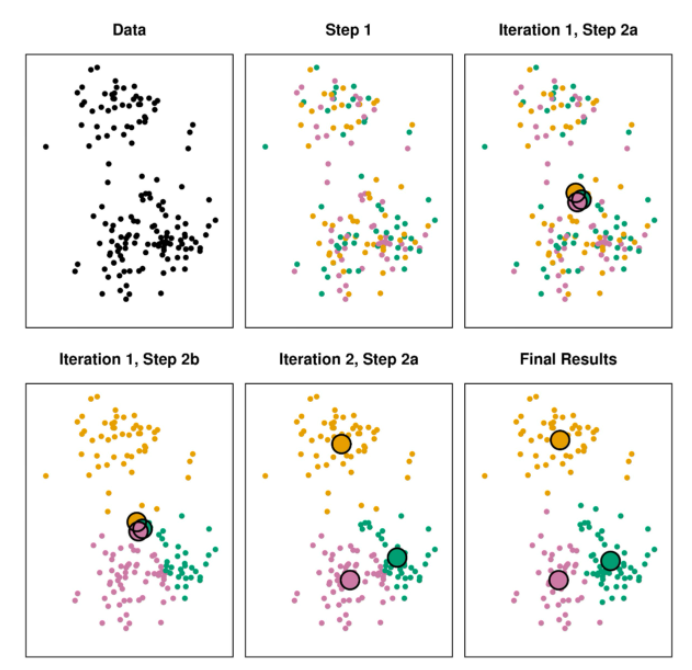

In [49]:
Image(filename='kmeans_iterations.png', width=600)
                                                      # --> step 1: assegna casualmente un cluster ad ogni istanza, con K=3.
    
                                                      #     iterazione 1, step 2a: calcola i centroidi dei tre cluster,
                                                      #     in genere vicini tra loro (in questa prima iterazione)
            
                                                      #     iterazione 1, step 2b: riassegna i cluster alle varie istanze
                                                      #     (quello il cui centroide è il meno distante dall'istanza stessa)
                    
                                                      #     iterazione 2, step 2a: calcola nuovamente i centroidi dei tre
                                                      #     cluster
                            
                                                      #     ecc .... sino al risultato finale (convergenza raggiunta)

In [50]:
# La funzione 'KMeans', oltre a produrre l'oggetto visto (il modello), memorizza le LABEL (il numero del cluster per ogni 
# osservazione) ed i CENTROIDI (mean vectors) di ogni cluster nei due oggetti seguenti, che sono accessibili direttamente:

In [92]:
print(type(kmeans.labels_)) # --> 'ndarray' è un datatype multi-dimensionale, qui vettoriale (non è Pandas)
print(len(kmeans.labels_))
print(kmeans.labels_)
print(kmeans.labels_[2])    # il terzo elemento (python conta da 0)
print(kmeans.labels_[0:3])  # i primi tre elementi (3 è escluso)

<class 'numpy.ndarray'>
4298
[0 1 1 ... 2 3 1]
1
[0 1 1]


In [93]:
# ed ora le coordinate dei CENTROIDI (mean vector) di ogni cluster:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=normalized_df.columns) 
                               # In 3+ dimensioni è comune il suffisso 'oide': centroide, paraboloide, ellissoide, ecc
                               # anzichè: centro, parabola, ellissi, come consueto in due dimensioni.
                               # Per i più precisi: in fisica il centroide corrisponde al centro di gravità (o baricentro) solo
                               # se il corpo è omogeneo.
                
                               # --> anche le coordinate (componenti del vettore) dei centroidi sono ovviamente
                               # per POSIZIONE e STANDARDIZZATA.
                        
pd.set_option('precision',3)
centroids

,TotalSales,OrderCount,AvgOrderValue
0,-0.144,-0.854,0.785
1,1.202,0.992,0.881
2,-1.243,-0.790,-1.063
3,0.237,0.733,-0.641


In [94]:
# calcolare la distanza di ogni osservazione dai centroidi di classe:
distances = kmeans.transform(normalized_df) 

# trovare il cluster più vicino ad ogni osservazione (min distance): 
minSquaredDistances = distances.min(axis=1)**2 

# combinare in un unico dataframe le min distance e le etichette dei cluster: 
df = pd.DataFrame({'squaredDistance': minSquaredDistances, 'cluster': kmeans.labels_}, 
                  index = normalized_df.index) 

# raggruppare per cluster e visualizzare: 
for cluster, data in df.groupby('cluster'): 
    count = len( data) 
    withinClustSS = data.squaredDistance.sum() 
    print(f'Cluster {cluster} ({count} members): {withinClustSS:.2f} within cluster ')

Cluster 0 (1064 members): 884.88 within cluster 
Cluster 1 (1131 members): 738.07 within cluster 
Cluster 2 (1157 members): 734.46 within cluster 
Cluster 3 (946 members): 686.57 within cluster 


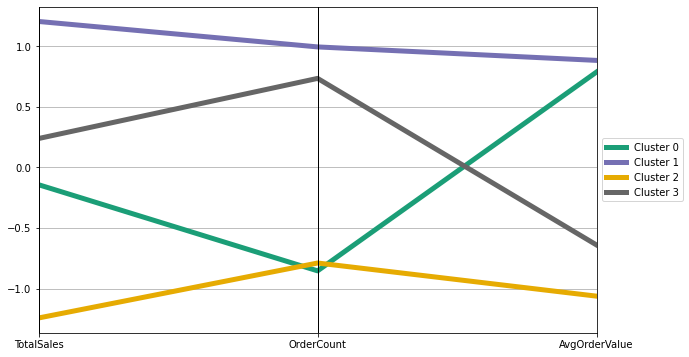

In [95]:
# il cosiddetto 'profile plot', cioè la rappresentazione grafica dei centroidi dei cluster:
centroids['cluster'] = ['Cluster {}'. format( i) for i in centroids.index] 
plt.figure(figsize =(10,6)) 
pd.plotting.parallel_coordinates(centroids, class_column ='cluster', colormap ='Dark2', linewidth = 5) 
plt.legend(loc ='center left', bbox_to_anchor =( 1, 0.5))

In [96]:
# Ora esaminiamo i cluster assegnati alle varie osservazioni:
four_cluster_df = normalized_df.copy(deep=True) 
                                            # copia del dataframe (dati ed indici) per valore anzichè per referenza (deep=False)
four_cluster_df['Cluster'] = kmeans.labels_ # salva le label di ogni riga (il cluster al quale la riga è stata
                                            # assegnata) in una quarta colonna.
four_cluster_df.head(20)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.725,-1.731,1.731,0
12347.0,1.457,1.064,1.401,1
12348.0,0.967,0.573,0.930,1
12349.0,0.944,-1.731,1.683,0
12350.0,-0.732,-1.730,0.332,0
12352.0,1.193,1.309,0.170,1
12353.0,-1.636,-1.729,-1.570,2
12354.0,0.509,-1.728,1.613,0
12355.0,-0.386,-1.727,0.971,0


In [97]:
# le cardinalità di ogni cluster:
four_cluster_df.groupby('Cluster').count()['TotalSales'] # --> 1171 + 935 + 1126 + 1066 = 4298.
                                                         # Il subsetting finale elimina info ridondanti.

Cluster
0    1064
1    1131
2    1157
3     946
Name: TotalSales, dtype: int64

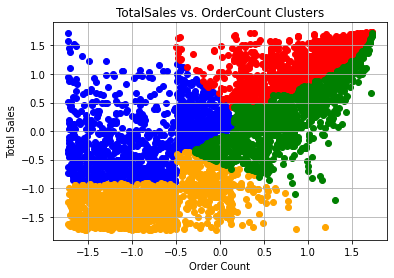

In [98]:
# e visualizziamo i cluster graficamente secondo le due dimensioni OrderCount e TotalSales:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    c='green'
)

plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()

In [58]:
# Si arriva qui alla INTERPRETAZIONE business (applicativa) del risultato.
# Cosa vediamo?
# Il cluster in arancione è quello dei clienti di "basso valore" (non hanno comprato molto i nostri prodotti).
# Il cluster in rosso è quello dei clienti "di alto valore" (hanno comprato molto e spesso).
# Gli altri cluster sono meno interessanti (K=4 è stato scelto a priori).
# La visualizzazione aiuta molto.

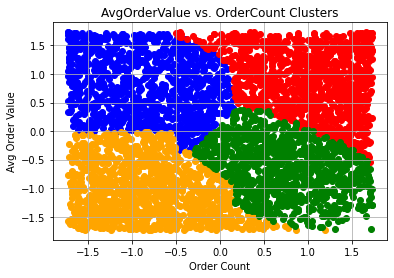

In [59]:
# Ovviamente, con TRE attributi del dataset, possiamo scegliere altre due coppie per la visualizzazione:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green'
)

plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

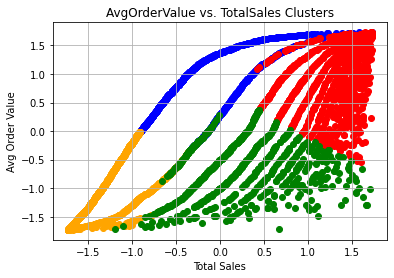

In [60]:
# ed infine:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange'
)

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green'
)

plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()

## La funzione obiettivo del k-means [Nota matematica facoltativa]
L'algoritmo k-means minimizza una funzione obiettivo così definita:<br><br>
minimize **Sum [j=1..K] WSS-j**<br>
C1, C2,..CK<br><br>
E' un problema di ottimizzazione molto difficile da risolvere in modo esatto (perchè WSS non è convessa ancorchè sia quadratica) se p (il numero di attributi del dataset) è anche solo medio (qualche decina). Fortunatamente, c'è un semplice algoritmo **iterativo** che permette di trovare delle soluzioni approssimate. [Eccolo](KmeansAlgorithm.png).<br><br>
Questo algoritmo trova un minimo locale, che non necessariamente, in funzioni non-convesse, corrisponde al minimo globale.
[Minimo locale vs minimo globale](LocMinvsGlobMin.png). Questa è la ragione dell'argomento *max_iter* di *KMeans*.<br><br>
K-means è così computazionalmente più performante del clustering gerarchico.

## Le distanze
Per variabili numeriche si può usare la distanza euclidea.<br>
Per variabili categoriche ci sono distanze apposite (ad es. [Jaccard](https://it.wikipedia.org/wiki/Indice_di_Jaccard)), e così per mix di variabili (numeriche e categoriche) (ad esempio [Gower](https://stats.stackexchange.com/questions/15287/hierarchical-clustering-with-mixed-type-data-what-distance-similarity-to-use/15313#15313)).


## Selezionare il numero di cluster "migliore"
Spesso, come nel caso di prima, non sappiamo in anticipo quale numero di cluster sia il migliore. Si può allora usare il **silhouette score**<br> che misura, A POSTERIORI, <u>quanto vicine le varie osservazioni siano ai loro rispettivi cluster ai quali sono stati assegnati dall'algoritmo</u>. Per ogni numero di cluster ipotizzato si calcola: <br><br>
***S = (b-a) / max (a,b)***<br><br>
dove:<br> 
* b è la media della distanza tra un'osservazione ed il suo cluster più vicino;
* a è la distanza media tra le osservazioni dello stesso cluster.<br>

Il Silhouette score assume valori tra **-1 ed 1**: più il suo valore è vicino a 1, migliore è la suddivisione dei dati fornita da <u>quel numero</u> di cluster.

In [99]:
from sklearn.metrics import silhouette_score  # import della funzione scikit-learn

In [100]:
# sperimentiamo sette differenti numeri di cluster.
# [la cella è in esecuzione sintantochè le quadre a sinistra della cella contengono '*' e non il numero di esecuzione.]
distortions = []
for n_cluster in [2,3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters=n_cluster).fit(normalized_df) # il fit del modello di clustering sui dati;
                                                             # come prima, è fatto sul dataframe 'normalized_df'.
    silhouette_avg = silhouette_score(normalized_df,kmeans.labels_)
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))
    distortions.append(kmeans.inertia_) # inertia sono le SS (preferibili per la curva a gomito?!)


Silhouette Score for 2 Clusters: 0.4288
Silhouette Score for 3 Clusters: 0.4133
Silhouette Score for 4 Clusters: 0.4117
Silhouette Score for 5 Clusters: 0.3773
Silhouette Score for 6 Clusters: 0.3784
Silhouette Score for 7 Clusters: 0.3912
Silhouette Score for 8 Clusters: 0.3812


In [64]:
type(distortions)
distortions

[6436.84237548107,
 4266.563831780174,
 3043.820132836192,
 2533.353531178834,
 2094.056053657302,
 1768.4598217689752,
 1532.4886367916]

Il miglior numero di cluster, quello che meglio suddivide i dati, è 2, come avevamo intuito già dal primo scatter plot.<br>
C'è comunque da notare che gli score delle sette sette suddivisioni sono molto vicini tra loro.

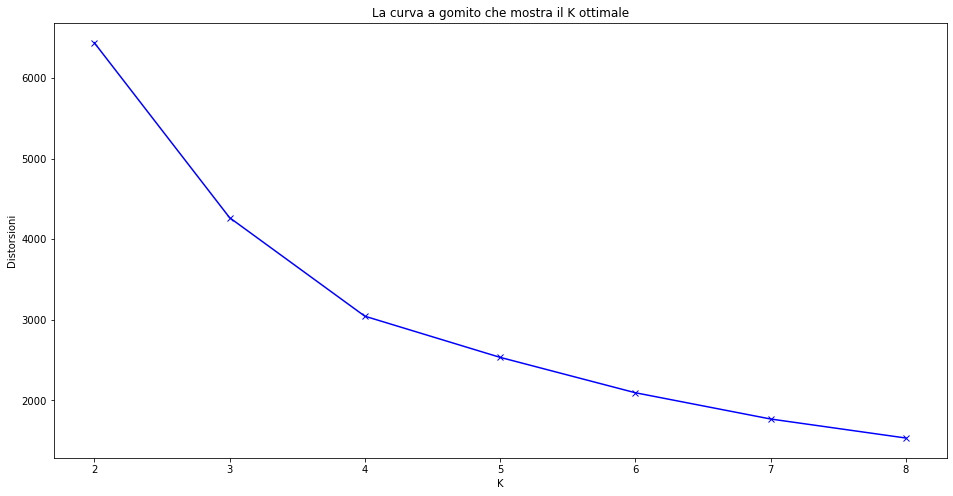

In [60]:
# Plot della curva a gomito: è una tecnica alternativa, GRAFICA (qui con le SS come metrica di confronto):
plt.figure(figsize=(16,8))
plt.plot(range(2,9), distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distorsioni')
plt.title('La curva a gomito che mostra il K ottimale')
plt.show()  # --> K ottimale è 4 o 5, anche se non c'è un chiaro gomito.

## Interpretare i Segmenti Cliente
Vediamo ora alcuni modi per ricavare "insight" dai risultati del clustering.

In [101]:
# clustering con 4 cluster (k=4 è interessante, sebbene non sia quello che fornisce il miglior coefficiente Silhouette):
kmeans = KMeans(n_clusters=4,random_state=1).fit(normalized_df)

In [102]:
# creazione di un nuovo dataframe con la (quarta) colonna 'cluster' (esattamente come fatto prima)
four_cluster_df = normalized_df.copy(deep=True) 
four_cluster_df['Cluster'] = kmeans.labels_
four_cluster_df.head()

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.725,-1.731,1.731,0
12347.0,1.457,1.064,1.401,1
12348.0,0.967,0.573,0.930,1
12349.0,0.944,-1.731,1.683,0
12350.0,-0.732,-1.730,0.332,0


In [103]:
print("         TotalSales","  OrderCount","  AvgOrderValue") # heading manuale 
kmeans.cluster_centers_                                       # i centroidi sono le medie dei cluster (mean vectors).

         TotalSales   OrderCount   AvgOrderValue


array([[-0.14398196, -0.85414751,  0.78536565],
       [ 1.20190252,  0.99212432,  0.88087794],
       [-1.24269424, -0.78956365, -1.06275347],
       [ 0.2368513 ,  0.73254711, -0.64098788]])

In [67]:
# Come si vede da questa tabella (array multi-dimensionale) che riporta i CENTROIDI dei 4 cluster:
# - il secondo cluster (quello rosso negli scatterplot) ha tutti e tre gli attributi medio-alti: cioè i clienti di questo cluster 
#   comprano spesso e comprano prodotti cari e quindi forniscono il venduto maggiore; in genere le aziende focalizzano le loro
#   azioni di marketing su questo segmento perchè è quello che darà il miglior ritorno;
# - il terzo cluster (quello in arancione negli scatterplot) è quello con i tre attributi più bassi: cioè i clienti di questo cluster
#   sono quelli di minor valore per l'azienda;

# --> se devo prendere solo due cluster (K=2), come suggerito dal silhouette score visto prima, effettivamente i cluster 
#   2 e 3 sono quelli maggiormente differenziati (tutte le componenti del centroide sono alte oppure basse).

# - il quarto cluster è interessante: i suoi clienti comprano abbastanza spesso ma l'importo medio dei loro ordini è basso: un
#   marketing di prodotti di basso valore dovrebbe avere un buon ritorno (cioè un buon rapporto costo/benefici);
# - infine anche il primo cluster è di un certo interesse: questi clienti danno un venduto medio-basso, però comprano 
#   prodotti cari (sebbene non spesso): dunque un marketing mirato ai prodotti cari dovrebbe risultare molto proficuo.

# --> K=4 ci ha comunque fornito delle indicazioni utili, ancorchè i 4 segmenti siano meno differenziati che 2.

**In sintesi**: grazie al <u>ranking</u> ed al <u>clustering</u>, possiamo confrontare i tre attributi dei vari cluster e capire come **differenziare le azioni di marketing in modo da garantirne un buon ritorno (ROI) dell'azione di marketing stessa**.<br>
I <u>centroidi</u> dei cluster ci aiutano a capire meglio i vari cluster (segmenti).

In [78]:
# Visual presentation (profile plot) of cluster centroids (DMfBA python) 

## I prodotti *best-seller* per segmento

Per finire, vediamo quali sono i prodotti che vendono meglio in ogni segmento (esempio con il cluster 2). E' molto utile.<br>
Per comodità, ricapitoliamo prima i vari dataframe sin qui creati:
* *df*: il dataframe di dettaglio (con i singoli ordini):
    * originale: cardinalità (541909, 8);
    * pulito (primi 4 step): cardinalità (380620, 8);
* *customer_df*: il dataframe pulito e raggruppato per cliente (3 attributi):
    * cardinalità (4298, 3);
* *rank_df*: il *customer_df* per posizioni (anzichè per valori):
    * cardinalità (4298, 3);
* *normalized_df*: il *rank_df* standardizzato:
    * cardinalità (4298, 3);
* *four_cluster_df*: il *normalized_df* con in più il cluster assegnato da KMeans (quarta colonna):
    * cardinalità (4298, 4). <br>

Siccome lo statement finale è un pò complesso procediamo a passi e check progressivi.

In [79]:
# step 1) estraiamo dall'ultimo dataframe creato le righe del cluster 1 (il secondo) e creiamo un nuovo dataframe 
# (relativo solo a C1).
high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 1]   # 1 è il secondo cluster (il migliore).
high_value_cluster.head()                                                   # le righe del cluster 2.

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12347.0,1.457,1.064,1.401,1
12348.0,0.967,0.573,0.930,1
12352.0,1.193,1.309,0.170,1
12356.0,1.269,0.158,1.557,1
12359.0,1.586,0.574,1.673,1


In [80]:
# per nostra comprensione, check VISIVO degli INDICI anzichè dei VALORI (costruiti in automatico da pandas alla creazione 
# del dataframe):
high_value_cluster.index # --> l'elenco dei clienti assegnati al cluster 2

Float64Index([12347.0, 12348.0, 12352.0, 12356.0, 12359.0, 12360.0, 12362.0,
              12370.0, 12372.0, 12380.0,
              ...
              18235.0, 18239.0, 18242.0, 18251.0, 18257.0, 18259.0, 18260.0,
              18263.0, 18272.0, 18287.0],
             dtype='float64', name='CustomerID', length=1131)

In [81]:
# altro check VISIVO, sempre per nostra comprensione:
df['CustomerID'].isin(high_value_cluster.index) # isin significa is-in?
                                                # produce un vettore di booleani con:
                                                # - True se il CustomerID della riga è compreso in quelli di C2
                                                # - False altrimenti

KeyError: 'CustomerID'

In [75]:
# step 2):
# - estraiamo dal dataset originario (col dettaglio) le righe con CustomerID contenuto nell'indice creato allo step 1);
#   si usa qui anche un subsetting booloeano (non vista nell'introduzione a pandas)
# - raggruppiamo per descrizione prodotto;
# - contiamo;
# - ordiniamo in modo discendente.
pd.DataFrame(
    df.loc[df['CustomerID'].isin(high_value_cluster.index)].groupby('Description').count()['StockCode'].sort_values(ascending=False).head()
)

KeyError: 'CustomerID'

In [71]:
# Al segmento 2 si possono dunque raccomandare prodotti simili a questi! Utile per le nostre campagne di marketing.

## Clustering con valori
Rimane un'ultima verifica da fare.<br>
Possiamo usare 'KMeans' con i **valori** anzichè le posizioni?<br>
Cioè eseguiamo lo stesso clustering k-means di prima (n_clusters=4,random_state=1) sul dataframe *customer_df* anzichè sul dataframe *rank_df*, ed ovviamente facciamo la standardizzazione preliminare dei dati (comunque necessaria nel clustering).

In [82]:
normalized_df = (customer_df - customer_df.mean()) / customer_df.std() # la standardizzazione
kmeans = KMeans(n_clusters=4,random_state=1).fit(normalized_df)
four_cluster_df = normalized_df.copy(deep=True) 
four_cluster_df['Cluster'] = kmeans.labels_
print(four_cluster_df.head()) # VALORI standardizzati (non ranked)
print("         TotalSales","  OrderCount","  AvgOrderValue") # heading manuale 
kmeans.cluster_centers_  

            TotalSales  OrderCount  AvgOrderValue  Cluster
CustomerID                                                
12346.0          9.004      -0.422         60.403        3
12347.0          0.255       0.252          0.221        0
12348.0         -0.019      -0.018          0.039        0
12349.0         -0.023      -0.422          1.068        0
12350.0         -0.194      -0.422         -0.052        0
         TotalSales   OrderCount   AvgOrderValue


array([[-1.03150800e-01, -1.46773209e-01, -3.20007754e-02],
       [ 1.25772478e+00,  2.34099823e+00,  2.72185527e-01],
       [ 1.45058145e+01,  1.17681783e+01,  1.41918358e+00],
       [ 9.00437610e+00, -4.22046161e-01,  6.04028573e+01]])

In [83]:
# Come si vede l'interpretazione dei centroidi dei cluster non è più così chiara!
# Ad esempio, non c'è più distinzione chiara tra cluster 3 (high-value) e cluster 1 (low-value)!
# Perchè succede questo? 
# Insight: i valori, ancorchè standardizzati, sono comunque influenzati dalla loro magnitudo. La posizione, no.
# Reminder: la mediana NON è influenzata dagli outlier, la media, sì.

## Altre applicazioni del k-means 

**Google News** usa il clustering k-means. Prende i news feed e li clusterizza al volo, con tecnologia *massive parallel*.